# Demo Explanations

Author: Miguel Angel Meza Martinez

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import lime
import lime.lime_tabular
import dice_ml
from anchor import anchor_tabular
import shap
import matplotlib.pyplot as plt

c:\sapdevelop\venvs\xai\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\sapdevelop\venvs\xai\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\sapdevelop\venvs\xai\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
utils_dir = './utils'
sys.path.append(utils_dir)

In [3]:
from explanation_utils import ExplanationUtils
import explanation_plots as ep
from DataLoader import data_loader
from importlib import reload

In [4]:
reload(ep)

<module 'explanation_plots' from './utils\\explanation_plots.py'>

In [5]:
# Read credit data
data = data_loader()

In [6]:
# Load tensorflow model
model = load_model('./model/smote.tf')

In [7]:
# Initialize utils object
exp_utils = ExplanationUtils(model, data)

In [8]:
# Preprocess data
exp_utils.data_preprocess()

# Preprocess for lime and anchor
X_train_le, X_test_le, feature_names, cat_names, cat_indices = exp_utils.exp_preprocess()

X = pd.concat([X_train_le, X_test_le])

## LIME

In [9]:
predict_fn_lime = exp_utils.get_prediction_function(exp_type='lime')
# Create explainer object, see https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular
# Open questions:
# - Kernel_width? Default is sqrt(num_features)*0.75
# - Discretize cintinuous features? If yes, can be quartile, decile and entropy
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_le.values, feature_names=feature_names,
                                                   class_names=['Approved', 'Rejected'], mode='classification',
                                                   categorical_features=cat_indices, categorical_names=cat_names,
                                                   feature_selection='lasso_path',
                                                   discretize_continuous=True)

In [10]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=feature_names,
                                                       class_names=['Approved', 'Rejected'], mode='classification',
                                                       categorical_features=cat_indices, categorical_names=cat_names,
                                                       feature_selection='lasso_path',
                                                       discretize_continuous=True)

Define instance to be explained

In [11]:
idx = 0

In [12]:
lime_exp = exp_utils.get_lime_exp(lime_explainer, predict_fn_lime, idx, 'train', num_features=18)

In [13]:
#file_name
file_name = os.path.join('./images/lime_' + '%02d'%idx + '.png')

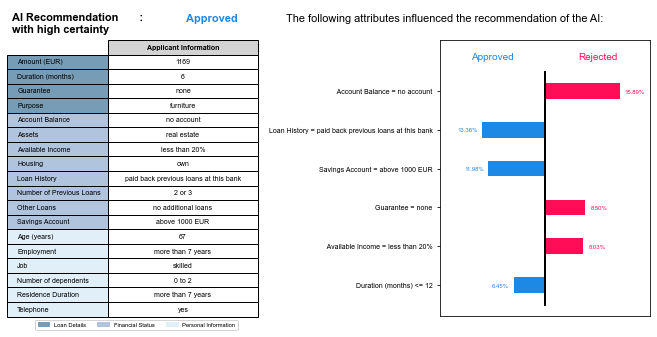

In [14]:
ep.lime_plot(exp_utils.X_train, idx, lime_exp, file_name, rename=True, num_features=6)

## Anchors

In [15]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    ['Approved', 'Rejected'],
    feature_names,
    X_train_le.values,
    cat_names,
    discretizer='quartile')

# Prediction function
predict_fn_anchor = exp_utils.get_prediction_function('anchor')

Define instance to be explained

In [16]:
idx = 0

In [17]:
anchor_exp, anchor_proba = exp_utils.get_anchor_exp(anchor_explainer, predict_fn_anchor, predict_fn_lime, idx, 'train', plot_mode=True, threshold=0.9)                                             

Prediction: Approved

Anchor: Savings Account = above 1000 EUR
AND Assets = real estate
Precision: 1.000
Coverage: 0.044

Instance:
 Account Balance                                        no account
Duration (months)                                               6
Loan History                paid back previous loans at this bank
Purpose                                                 furniture
Amount (EUR)                                               1169.0
Savings Account                                    above 1000 EUR
Employment                                      more than 7 years
Available Income                                    less than 20%
Guarantee                                                    none
Residence Duration                              more than 7 years
Assets                                                real estate
Age (years)                                                    67
Other Loans                                   no additional loans
Housing  

In [18]:
#file_name
file_name = os.path.join('./images/anchors_' + '%02d'%idx + '.png')

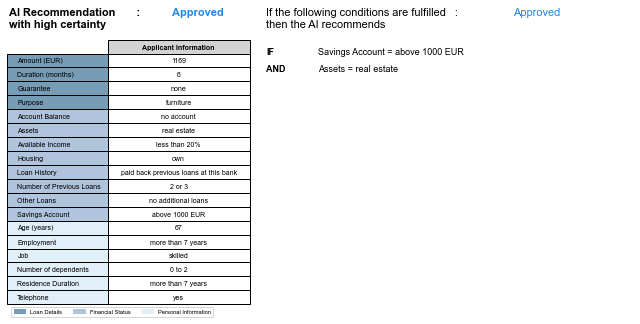

In [19]:
ep.anchor_plot(exp_utils.X_train, idx, anchor_exp, anchor_proba, file_name, rename=True)

## DICE

In [20]:
# Create data object. Specify the continours features and outcome variable
d = dice_ml.Data(dataframe=exp_utils.train_data, continuous_features=['Duration (months)', 'Amount (EUR)', 'Age (years)'], outcome_name='label')
# Provide the trained ML model to DiCE's model object
backend = 'TF'+tf.__version__[0]
m = dice_ml.Model(model=exp_utils.model, backend=backend)
# Create explainer object with trained model and data object
dice_explainer = dice_ml.Dice(d, m)

In [21]:
idx=0

In [22]:
dice_exp = exp_utils.get_dice_exp(dice_explainer, idx, 'train', total_CFs=3, desired_class='opposite')

Diverse Counterfactuals found! total time taken: 00 min 32 sec
Query instance (original outcome : 0)


,Account Balance,Duration (months),Loan History,Purpose,Amount (EUR),Savings Account,Employment,Available Income,Guarantee,Residence Duration,Assets,Age (years),Other Loans,Housing,Number of Previous Loans,Job,Number of dependents,Telephone,label
0,no account,6.0,paid back previous loans at this bank,furniture,1169.0,above 1000 EUR,more than 7 years,less than 20%,none,more than 7 years,real estate,67.0,no additional loans,own,2 or 3,skilled,0 to 2,yes,0.062



Diverse Counterfactual set (new outcome: 1.0)


,Account Balance,Duration (months),Loan History,Purpose,Amount (EUR),Savings Account,Employment,Available Income,Guarantee,Residence Duration,Assets,Age (years),Other Loans,Housing,Number of Previous Loans,Job,Number of dependents,Telephone,label
0,-,-,other loans exist at other banks,vacation,1790.2,no savings account at this bank,-,-,-,-,none,-,at other banks,-,-,-,-,-,0
1,-,37.0,delay payment of previous loans,business,4017.5,no savings account at this bank,-,-,-,-,-,-,-,-,-,-,-,-,0
2,-,-,paid back all previous loans,-,1168.9999999998754,-,less than 1 year,-,-,-,none,-,-,-,-,-,-,-,0


In [23]:
#file_name
file_name = os.path.join('./images/dice_' + '%02d'%idx + '.png')

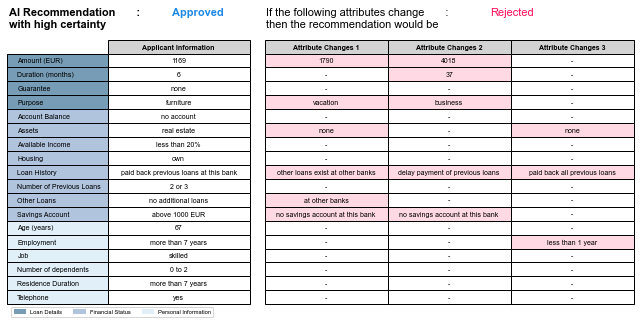

In [24]:
ep.dice_plot(exp_utils.X_train, idx, dice_exp, file_name, version='0.5', fill_empty='-', fill_cell=True, alignment='center', rename=True)

## SHAP

We generated all images running the python scripts instead of jupyter notebooks. It seems that for SHAP, there is a problem with the way the plot is generated inside of the notebook.
You can run the scrip separately to reproduce the image

In [25]:
predict_fn_shap = exp_utils.get_prediction_function(exp_type='shap')

shap_explainer = shap.KernelExplainer(predict_fn_shap, exp_utils.X_train)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [26]:
idx=0

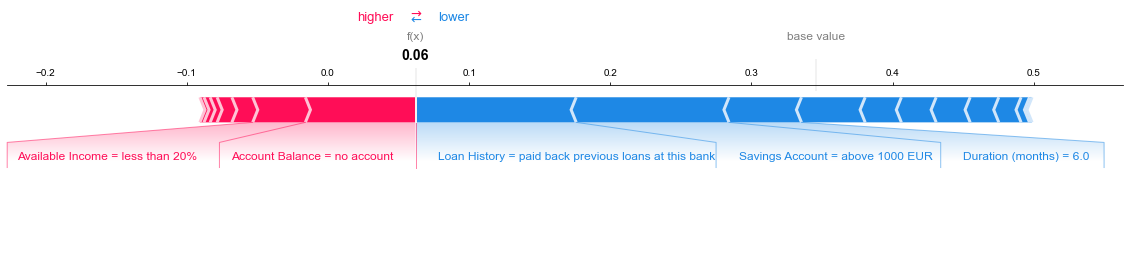

In [27]:
shap_values = exp_utils.get_shap_exp(shap_explainer, idx, 'train', nsamples=500, l1_reg='num_features(18)', visualize=True)

In [28]:
#file_name
file_name = os.path.join('./images/shap_' + '%02d'%idx + '.png')

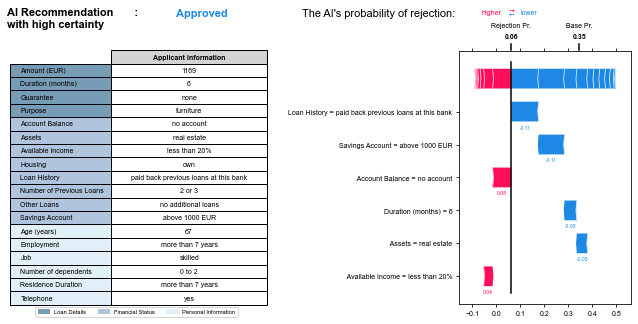

In [29]:
ep.shap_plot(exp_utils.X_train, idx, shap_explainer, shap_values, predict_fn_shap, file_name, rename=True, num_features=6)